In [1]:
import config
import sqlalchemy
import functions
import statsapi as mlb
import sql_alch_schema
from datetime import datetime

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String,DateTime,Date,Time,Boolean,func
from sqlalchemy import ForeignKey,and_
from sqlalchemy.orm import relationship
from sqlalchemy.schema import Table
from sqlalchemy import distinct

_sql_alchemy_connection = (
                                f'mysql+mysqlconnector://'
                                f'{config.user}:{config.password}'
                                f'@{config.host}:{config.port}'
                                f'/{config.schema}'
                           )
## Create the engine 
db = sqlalchemy.create_engine(_sql_alchemy_connection,
                              echo = False,
                              connect_args = {'ssl_disabled' : True,})

Base = sql_alch_schema.Base

Game = sql_alch_schema.Game
Play = sql_alch_schema.Play
Team = sql_alch_schema.Team
GameTeamLink = sql_alch_schema.GameTeamLink
Person = sql_alch_schema.Person


from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=db)
session = Session()

#Base.metadata.create_all(db)


import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

In [2]:
extra_features_df=functions.getGame_df()
df=functions.load_dataset(session)

grand_df=pd.merge(left=df,
                  right=extra_features_df,
                  left_on='ID',
                  right_on='id')
grand_df['homeTeam_win']=grand_df.apply(lambda x: 1 if x['home_score']>x['away_score'] else 0,axis=1)
#df['homeTeam_win']=grand_df.apply(lambda x: 1 if x['home_score']>x['away_score'] else 0,axis=1)


## Dummy Classifier
If I didn't know anything, I would pick the team with the higher win percentage every time. 

In [3]:
def trailing_winPct(row):
    home_wins=(grand_df[
        (grand_df['homeTeam_id']==row['homeTeam_id'])
        &(grand_df['ID']<row['ID'])]
               ['homeTeam_win'].sum())
    
    away_wins=(grand_df[
        (grand_df['awayTeam_id']==row['homeTeam_id'])
        &(grand_df['ID']<row['ID'])
        &(grand_df['homeTeam_win']==0)].shape[0])
    
    total_games=(grand_df[
        ((grand_df['homeTeam_id']==row['homeTeam_id'])|(grand_df['awayTeam_id']==row['homeTeam_id']))
        &(grand_df['ID']<row['ID'])].shape[0])
    return (home_wins+away_wins)/total_games

def away_trailing_winPct(row):
    home_wins=(grand_df[
        (grand_df['homeTeam_id']==row['awayTeam_id'])
        &(grand_df['ID']<row['ID'])]
               ['homeTeam_win'].sum())
    
    away_wins=(grand_df[
        (grand_df['awayTeam_id']==row['awayTeam_id'])
        &(grand_df['ID']<row['ID'])
        &(grand_df['homeTeam_win']==0)].shape[0])
    
    total_games=(grand_df[
        ((grand_df['homeTeam_id']==row['awayTeam_id'])|(grand_df['awayTeam_id']==row['awayTeam_id']))
        &(grand_df['ID']<row['ID'])].shape[0])
    return (home_wins+away_wins)/total_games

df['homeWin_pct']=grand_df.apply(lambda x: trailing_winPct(x),axis=1)

df['awayWin_pct']=grand_df.apply(lambda x: away_trailing_winPct(x),axis=1)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars


In [4]:
from sklearn.base import BaseEstimator

class WinPercentageClassifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        preds=X.apply(lambda row: 1 if row['homeWin_pct']>row['awayWin_pct'] else 0,axis=1)
        return preds

In [5]:
import sklearn
from sklearn.model_selection import train_test_split

X=df.drop(columns=['ID','home_score','away_score',])
y=df.apply(lambda x: 1 if x['home_score']>x['away_score'] else 0,axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=12)

In [6]:
dummy = WinPercentageClassifier()

In [7]:
dummy.fit(X_train)
dummy_preds = dummy.predict(X_test)

In [8]:
dummy_preds.value_counts()

1    489
0    483
dtype: int64

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,roc_curve

print(f1_score(y_test,dummy_preds))
np.mean(cross_val_score(dummy,X,y,cv=5,scoring='accuracy'))

0.5731584258324924


0.5793405890156091

## Create a model to beat the dummy

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold,StratifiedKFold

### Cross Validate Function // Plot confusion matrix function

In [11]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics

In [12]:
def plot_confusion_matrix(true,predicted):
    import itertools
    cm=confusion_matrix(true,predicted)
    classes=['Home Team Loss','Home Team Win']
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm,cmap=plt.cm.Blues)
    plt.title('Confusion matrix',fontdict={'size':20})
    fig.colorbar(cax)
    ax.set_xticklabels([''] + classes,fontdict={'size':14})
    ax.set_yticklabels([''] + classes,fontdict={'size':14})
    plt.xlabel('Predicted',fontdict={'size':14})
    plt.ylabel('True',fontdict={'size':14})
    plt.grid(b=None)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             fontdict={'size':14,'weight':'heavy'},
             color="black" if cm[i, j] > thresh else "black")
    plt.show()

In [13]:
def pipeline_cv(splits, X, Y, pipeline, average_method=None):
    
    kfold = KFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    roc_auc_scores = []
    for train, test in kfold.split(X, Y):
        fit = pipeline.fit(X.iloc[train], Y[train])
        prediction = fit.predict(X.iloc[test])
        
        scores = fit.score(X.iloc[test],Y[test])
        
        display(pd.DataFrame(metrics.classification_report(Y[test],prediction,output_dict=True)))
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction)*100)
        
        #print('precision:',precision_score(Y[test], prediction))
        recall.append(recall_score(Y[test], prediction)*100)
        #print('recall:   ',recall_score(Y[test], prediction))
        f1.append(f1_score(Y[test], prediction)*100)
        #print('f1 score: ',f1_score(Y[test], prediction))
        #print('-'*50)
        
        roc_auc_scores.append(roc_auc_score(Y[test],prediction)*100)
        
        plot_confusion_matrix(Y[test],prediction)
        
        

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    print("roc_auc score: %.2f%% (+/- %.2f%%)" % (np.mean(roc_auc_scores), np.std(roc_auc_scores)))

In [14]:
from sklearn.base import TransformerMixin

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_hitters_slashInteraction = True):
        self.add_hitters_slashInteraction=add_hitters_slashInteraction
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.add_hitters_slashInteraction:
            #X.loc[:,'homeHitter_slashInteraction']=X.apply(lambda row:row['home_hitters_OBP_mean']*row['home_hitters_SLG_mean'],axis=1)
            X.loc[:,'homeHitter_slashInteraction'] = (X.loc[:,'home_hitters_OBP_mean']
                                           *X.loc[:,'home_hitters_SLG_mean']
                                           *X.loc[:,'home_hitters_BA_mean'])
            X.loc[:,'awayHitter_slashInteraction'] = (X.loc[:,'away_hitters_OBP_mean']
                                           *X.loc[:,'away_hitters_SLG_mean']
                                           *X.loc[:,'away_hitters_BA_mean'])
                
            
            return X        
        else:
            pass

In [15]:
#interaction variables
from sklearn.preprocessing import PolynomialFeatures

### Logistic Regression

,0,1,accuracy,macro avg,weighted avg
precision,0.605701,0.606171,0.605967,0.605936,0.605942
recall,0.540254,0.668000,0.605967,0.604127,0.605967
f1-score,0.571109,0.635585,0.605967,0.603347,0.604276
support,472.000000,500.000000,0.605967,972.000000,972.000000


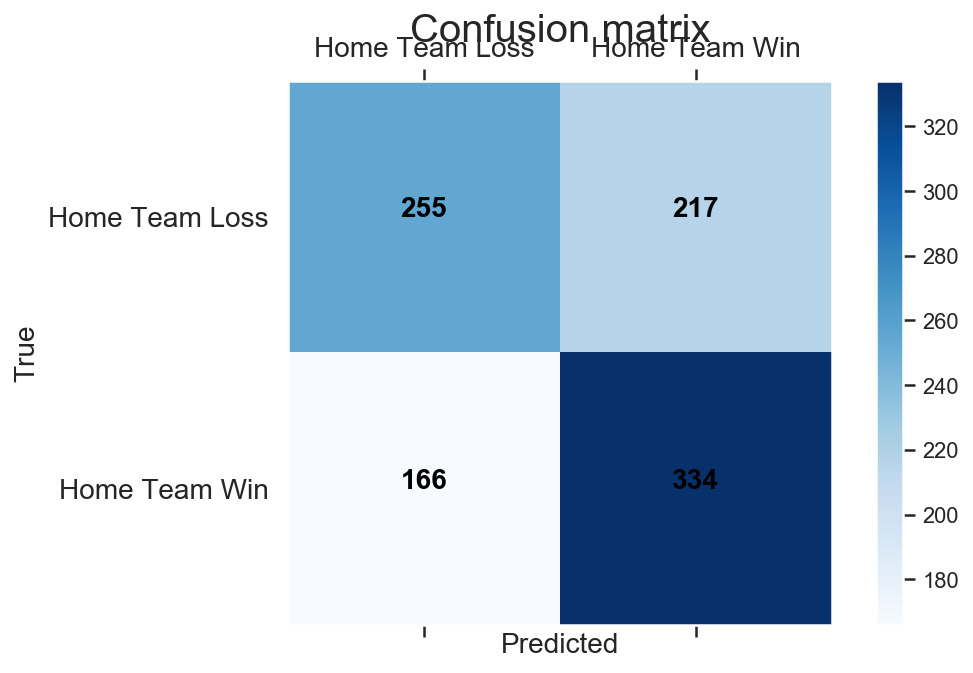

,0,1,accuracy,macro avg,weighted avg
precision,0.532808,0.580372,0.561728,0.556590,0.558303
recall,0.450111,0.658349,0.561728,0.554230,0.561728
f1-score,0.487981,0.616906,0.561728,0.552444,0.557086
support,451.000000,521.000000,0.561728,972.000000,972.000000


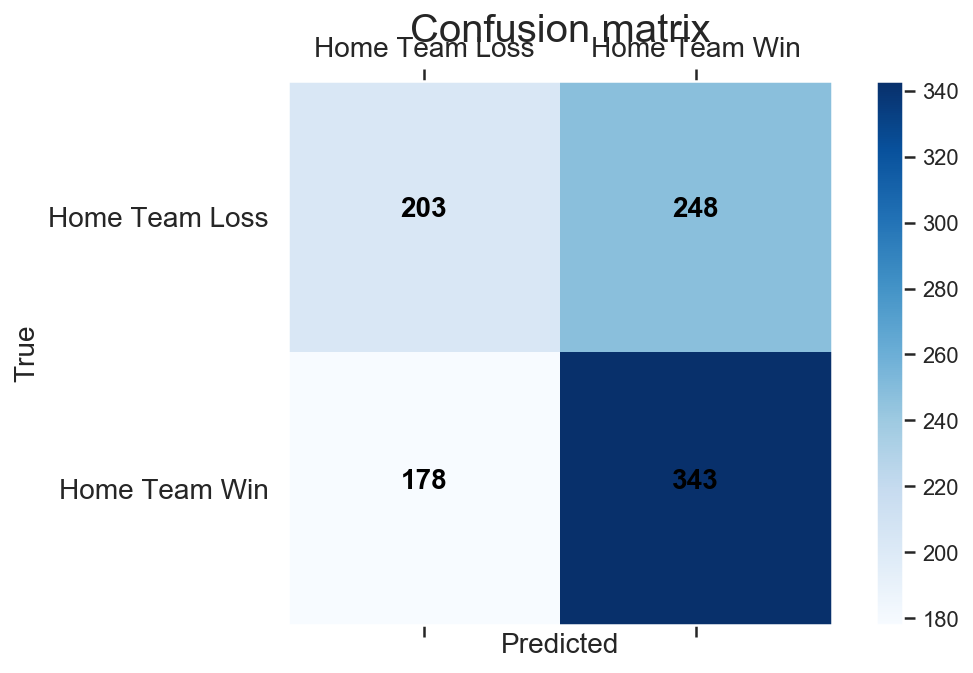

,0,1,accuracy,macro avg,weighted avg
precision,0.534527,0.574871,0.558642,0.554699,0.555944
recall,0.458333,0.647287,0.558642,0.552810,0.558642
f1-score,0.493506,0.608933,0.558642,0.551220,0.554783
support,456.000000,516.000000,0.558642,972.000000,972.000000


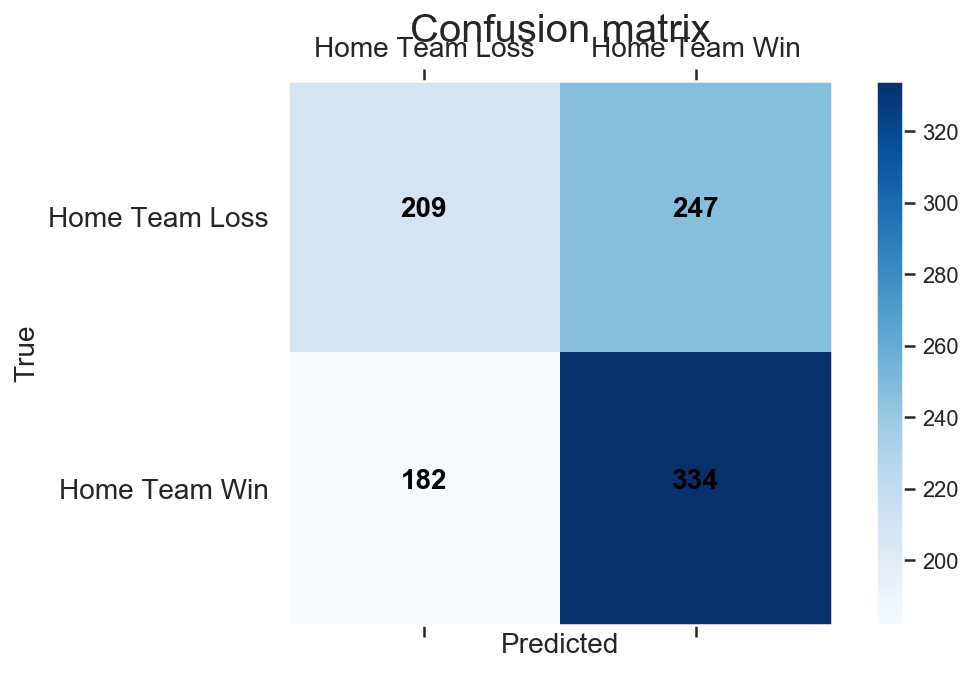

,0,1,accuracy,macro avg,weighted avg
precision,0.569832,0.584691,0.579218,0.577261,0.577674
recall,0.444444,0.699805,0.579218,0.572125,0.579218
f1-score,0.499388,0.637090,0.579218,0.568239,0.572064
support,459.000000,513.000000,0.579218,972.000000,972.000000


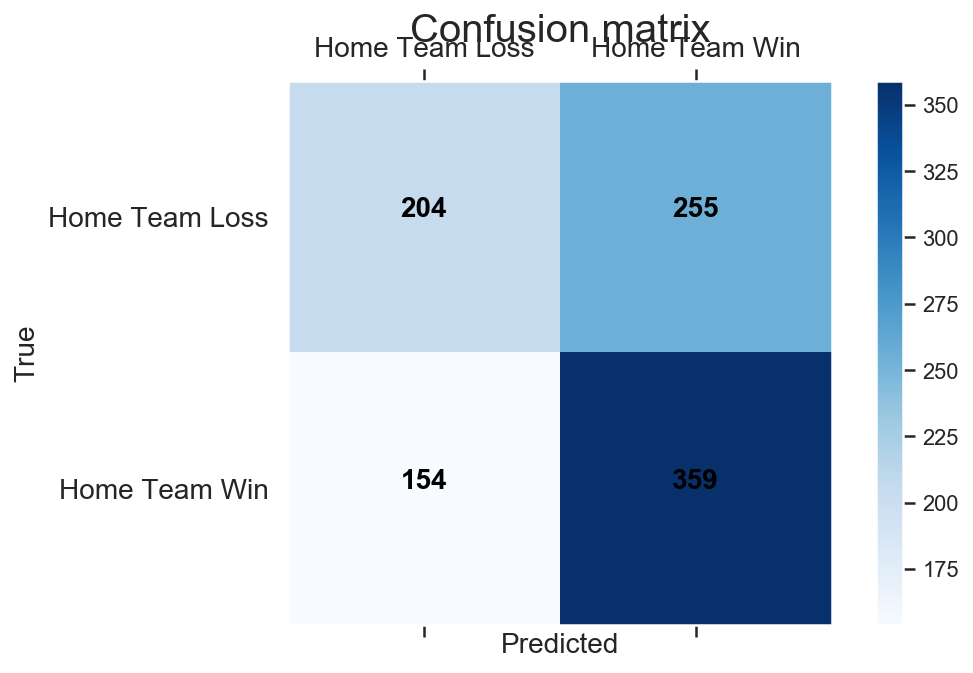

,0,1,accuracy,macro avg,weighted avg
precision,0.542328,0.581788,0.566426,0.562058,0.563379
recall,0.452539,0.666023,0.566426,0.559281,0.566426
f1-score,0.493381,0.621062,0.566426,0.557222,0.561495
support,453.000000,518.000000,0.566426,971.000000,971.000000


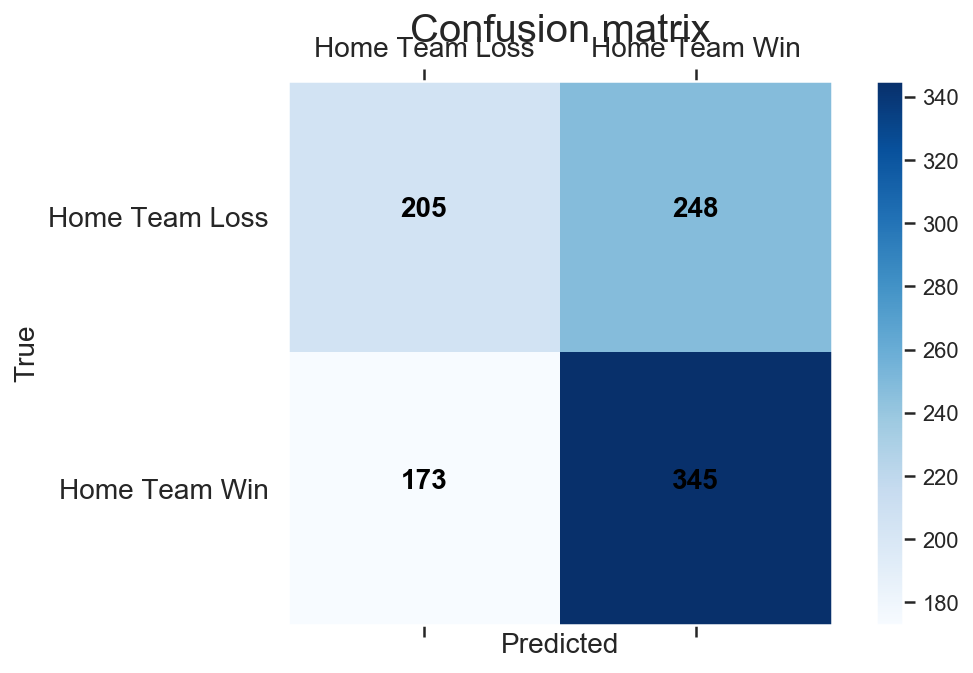

accuracy: 57.44% (+/- 1.73%)
precision: 58.56% (+/- 1.08%)
recall: 66.79% (+/- 1.75%)
f1 score: 62.39% (+/- 1.09%)
roc_auc score: 56.85% (+/- 1.91%)


In [16]:
lr_clf = LogisticRegression(max_iter=1000)

lr_pipe=Pipeline([
    ('nan_imputer',SimpleImputer(strategy='mean')),
    ('zero_imputer',SimpleImputer(missing_values=0,strategy='mean')),
    ('interaction',PolynomialFeatures(degree=1)),
    ('scaler',StandardScaler()),
    (('classifier',lr_clf))
])

pipeline_cv(5,X,y,lr_pipe)

##### random search Logistic Regression 

In [19]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import metrics
import numpy as np

# scoring metrics
f1_scorer = metrics.make_scorer(metrics.f1_score, average = 'weighted')
precision_scorer = metrics.make_scorer(metrics.precision_score)
recall_scorer = metrics.make_scorer(metrics.recall_score)
accuracy_scorer = metrics.make_scorer(metrics.accuracy_score)
auc_scorer = metrics.make_scorer(metrics.roc_auc_score)

In [33]:
lr_random_search_params = {
    'zero_imputer__strategy':['mean','median','most_frequent'],
    'nan_imputer__strategy':['mean','median','most_frequent'],
    'interaction__degree':[1],
    'scaler__with_std':[False,True],
    'scaler__with_mean':[True,False],
    'classifier__solver':['liblinear'],
    'classifier__penalty':['l1','l2'],
    'classifier__intercept_scaling':np.linspace(.3,.9,num=15),
    'classifier__max_iter':[1000],
    'classifier__C':np.linspace(1.4,1.8,num=15)
}

In [42]:
lr_random_search = RandomizedSearchCV(lr_pipe,
                                      lr_random_search_params,
                                      cv=5,n_jobs=-1,
                                      scoring=auc_scorer,verbose=0)

,0,1,accuracy,macro avg,weighted avg
precision,0.564341,0.580513,0.574074,0.572427,0.572796
recall,0.470893,0.668241,0.574074,0.569567,0.574074
f1-score,0.513399,0.621295,0.574074,0.567347,0.569812
support,773.000000,847.000000,0.574074,1620.000000,1620.000000


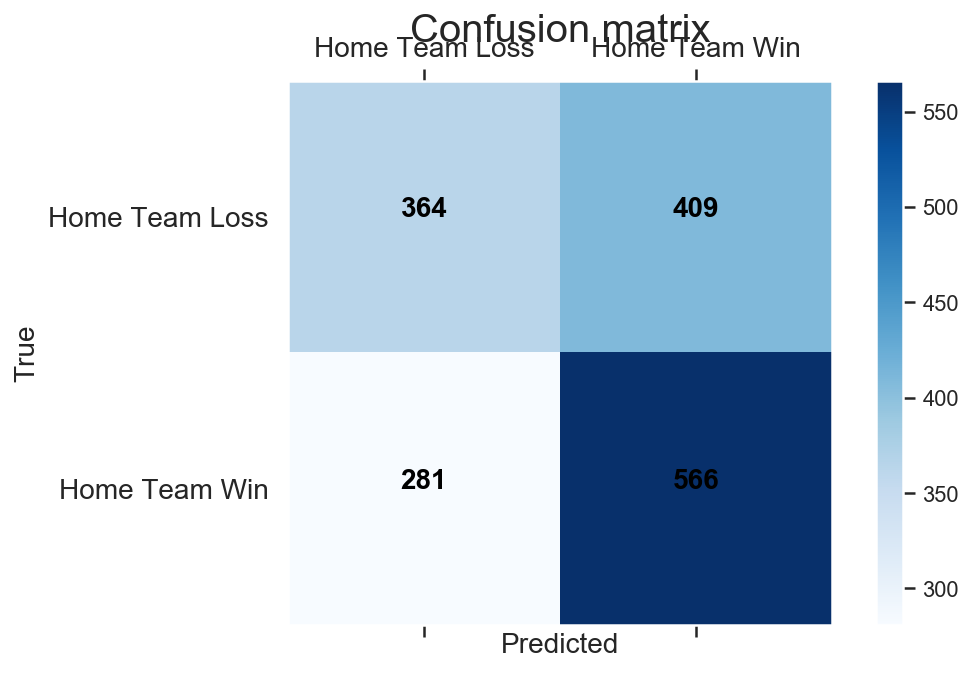

,0,1,accuracy,macro avg,weighted avg
precision,0.540000,0.578351,0.562963,0.559175,0.560359
recall,0.461842,0.652326,0.562963,0.557084,0.562963
f1-score,0.497872,0.613115,0.562963,0.555494,0.559050
support,760.000000,860.000000,0.562963,1620.000000,1620.000000


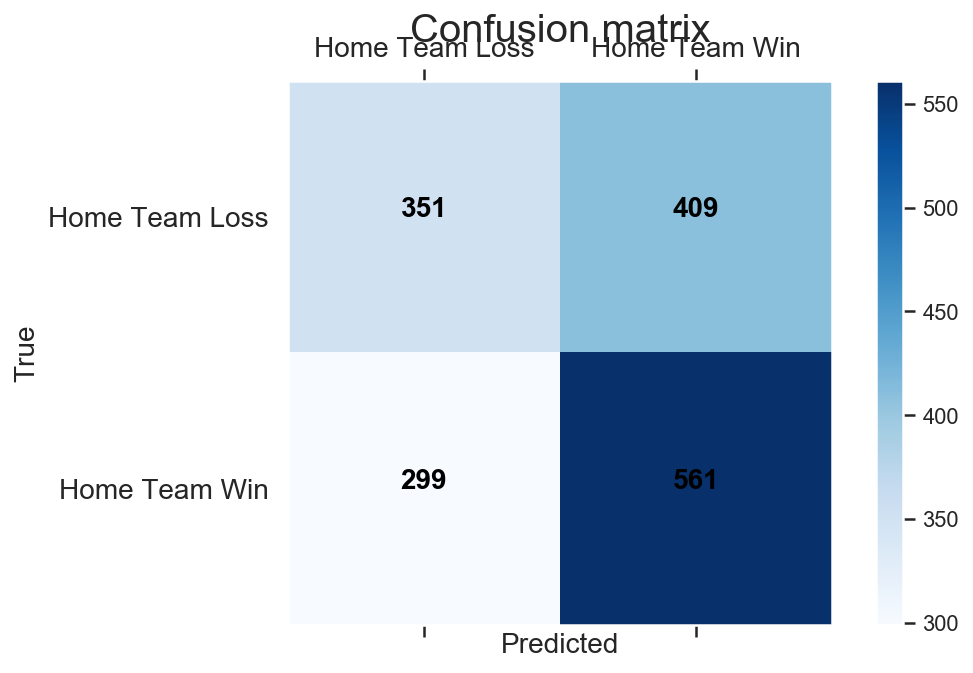

,0,1,accuracy,macro avg,weighted avg
precision,0.572816,0.596404,0.5874,0.584610,0.585360
recall,0.467018,0.693380,0.5874,0.580199,0.587400
f1-score,0.514535,0.641246,0.5874,0.577890,0.581921
support,758.000000,861.000000,0.5874,1619.000000,1619.000000


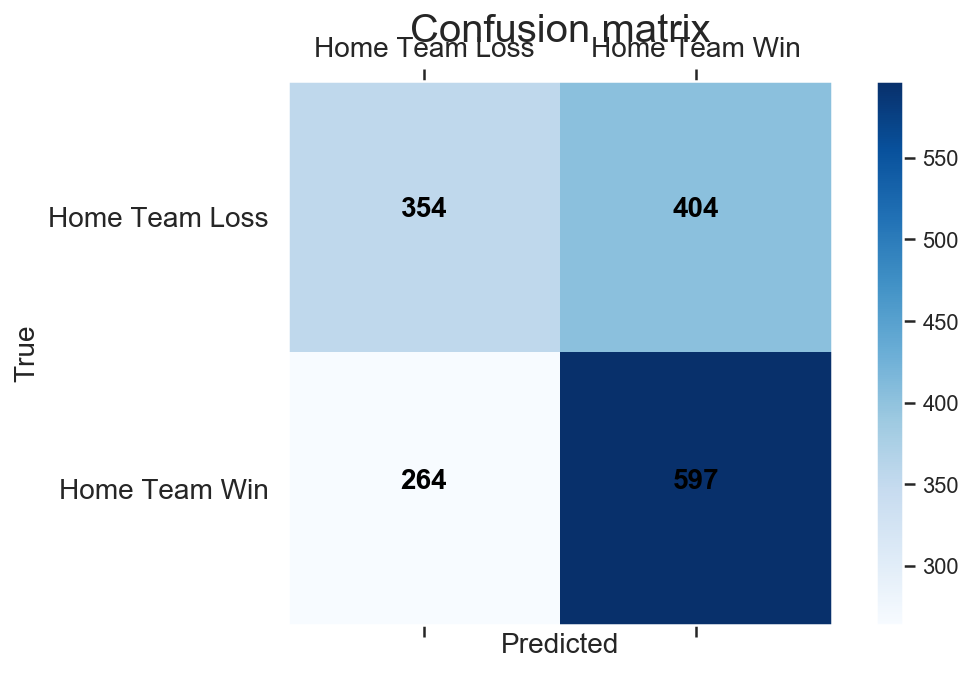

accuracy: 56.89% (+/- 0.94%)
precision: 58.51% (+/- 0.80%)
recall: 67.13% (+/- 1.69%)
f1 score: 62.52% (+/- 1.18%)
roc_auc score: 56.89% (+/- 0.94%)


In [43]:
pipeline_cv(3,X,y,lr_random_search)

In [44]:
lr_random_search.best_params_

{'zero_imputer__strategy': 'mean',
 'scaler__with_std': False,
 'scaler__with_mean': True,
 'nan_imputer__strategy': 'median',
 'interaction__degree': 1,
 'classifier__solver': 'liblinear',
 'classifier__penalty': 'l2',
 'classifier__max_iter': 1000,
 'classifier__intercept_scaling': 0.8142857142857143,
 'classifier__C': 1.5428571428571427}

In [45]:
lr_grid_search_params = {
    'zero_imputer__strategy':['mean','median','most_frequent'],
    'nan_imputer__strategy':['mean','median','most_frequent'],
    'interaction__degree':[1],
    'scaler__with_std':[False,True],
    'scaler__with_mean':[True,False],
    'classifier__solver':['liblinear'],
    'classifier__penalty':['l1','l2'],
    'classifier__intercept_scaling':[.4,.6,.8],
    'classifier__max_iter':[1000],
    'classifier__C':[1.5,1.6,1.7]
}

In [46]:
lr_grid_search = GridSearchCV(lr_pipe,lr_grid_search_params,cv=5,n_jobs=-1,scoring=auc_scorer,verbose=0)

In [ ]:
pipeline_cv(3,X,y,lr)

### Random Forest Classifier

,0,1,accuracy,macro avg,weighted avg
precision,0.563855,0.572711,0.56893,0.568283,0.568411
recall,0.495763,0.638000,0.56893,0.566881,0.568930
f1-score,0.527621,0.603595,0.56893,0.565608,0.566702
support,472.000000,500.000000,0.56893,972.000000,972.000000


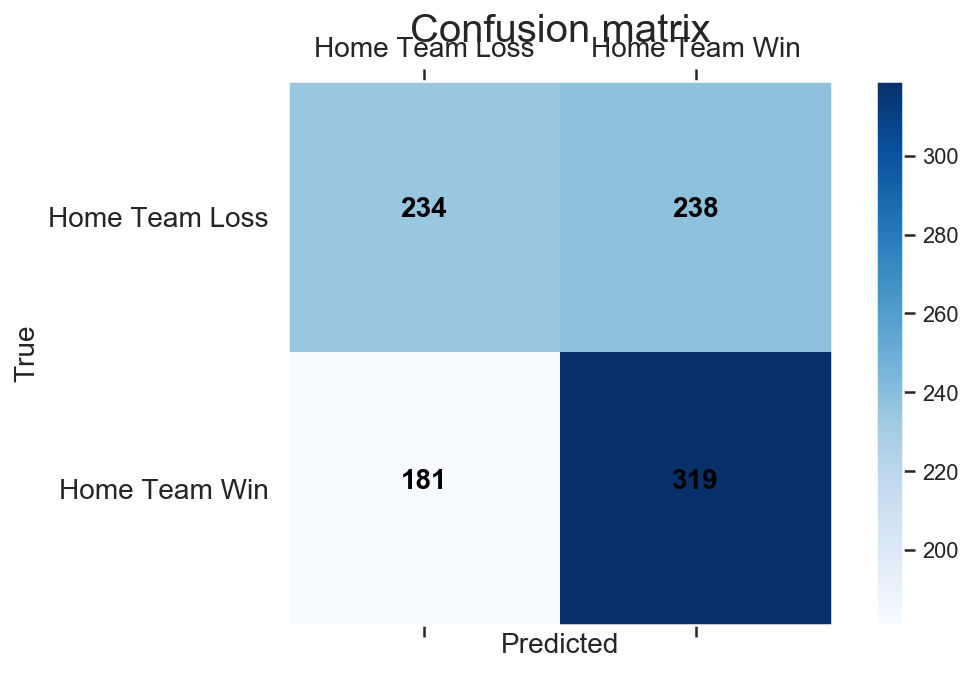

,0,1,accuracy,macro avg,weighted avg
precision,0.514925,0.571930,0.548354,0.543428,0.545480
recall,0.458980,0.625720,0.548354,0.542350,0.548354
f1-score,0.485346,0.597617,0.548354,0.541481,0.545524
support,451.000000,521.000000,0.548354,972.000000,972.000000


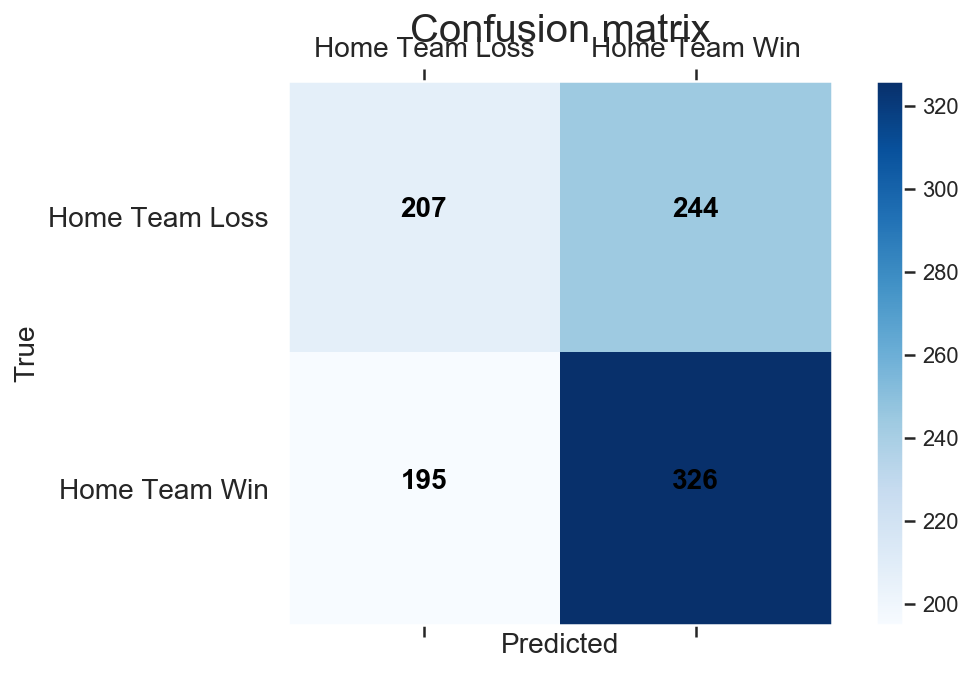

,0,1,accuracy,macro avg,weighted avg
precision,0.540046,0.588785,0.566872,0.564415,0.565920
recall,0.517544,0.610465,0.566872,0.564004,0.566872
f1-score,0.528555,0.599429,0.566872,0.563992,0.566180
support,456.000000,516.000000,0.566872,972.000000,972.000000


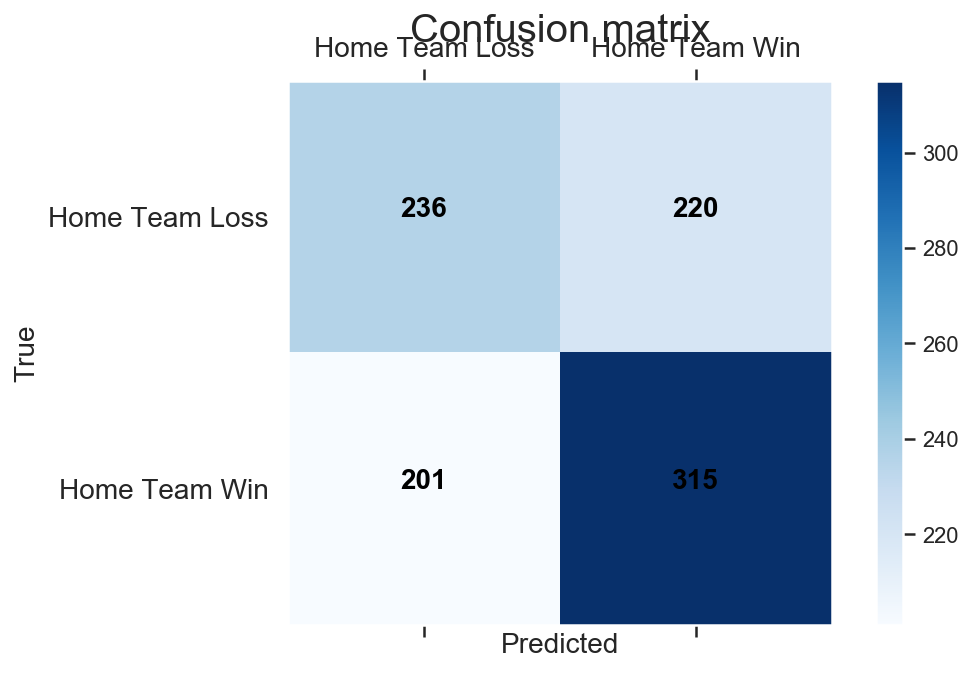

,0,1,accuracy,macro avg,weighted avg
precision,0.530457,0.567474,0.552469,0.548965,0.549994
recall,0.455338,0.639376,0.552469,0.547357,0.552469
f1-score,0.490035,0.601283,0.552469,0.545659,0.548749
support,459.000000,513.000000,0.552469,972.000000,972.000000


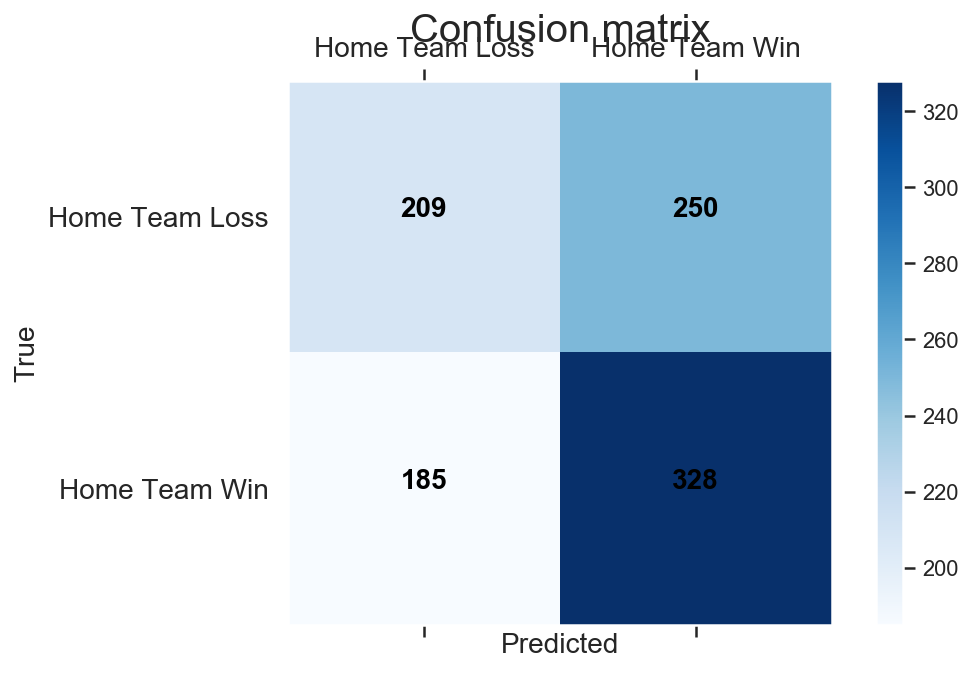

,0,1,accuracy,macro avg,weighted avg
precision,0.501235,0.558304,0.534501,0.529769,0.531679
recall,0.448124,0.610039,0.534501,0.529081,0.534501
f1-score,0.473193,0.583026,0.534501,0.528110,0.531786
support,453.000000,518.000000,0.534501,971.000000,971.000000


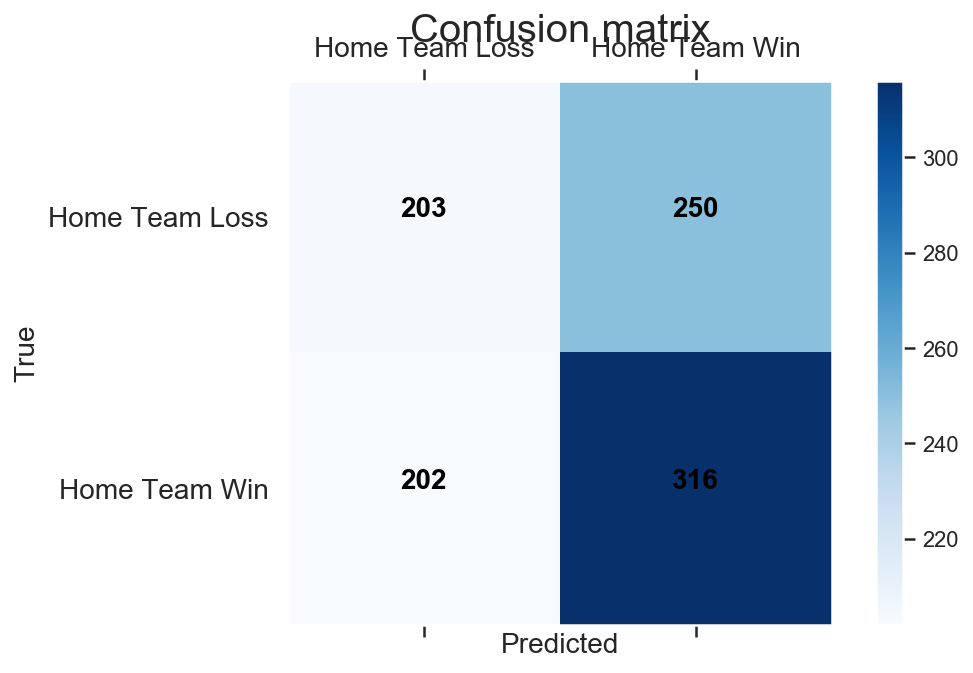

accuracy: 55.42% (+/- 1.27%)
precision: 57.18% (+/- 0.99%)
recall: 62.47% (+/- 1.27%)
f1 score: 59.70% (+/- 0.73%)
roc_auc score: 54.99% (+/- 1.40%)


In [107]:
rf_clf = RandomForestClassifier()

rf_pipe=Pipeline([
    ('nan_imputer',SimpleImputer(strategy='mean')),
    ('zero_imputer',SimpleImputer(missing_values=0,strategy='mean')),
    ('interaction',PolynomialFeatures(degree=1)),
    ('scaler',StandardScaler()),
    (('classifier',rf_clf))
])

pipeline_cv(5,X,y,rf_pipe)

In [108]:
rf_search_params = {
    'zero_imputer__strategy':['mean','median','most_frequent'],
    'nan_imputer__strategy':['mean','median','most_frequent'],
    'interaction__degree':[1],
    'scaler__with_std':[False,True],
    'scaler__with_mean':[True,False],
    'classifier__n_estimators':list(range(50,150)),
    'classifier__criterion':['gini','entropy'],
    'classifier__max_depth':np.linspace(1,32,32,endpoint=True),
    'classifier__min_samples_split':np.linspace(0.1, 1.0, 10, endpoint=True),
    'classifier__min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True),
    'classifier__max_features':list(range(1,X.shape[1]))
}

In [109]:
rf_search = RandomizedSearchCV(rf_pipe,rf_search_params,cv=5,n_jobs=-1,scoring=auc_scorer,verbose=0)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    5.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.0s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.599251,0.582873,0.588272,0.591062,0.590688
recall,0.413972,0.747344,0.588272,0.580658,0.588272
f1-score,0.489671,0.654941,0.588272,0.572306,0.576080
support,773.000000,847.000000,0.588272,1620.000000,1620.000000


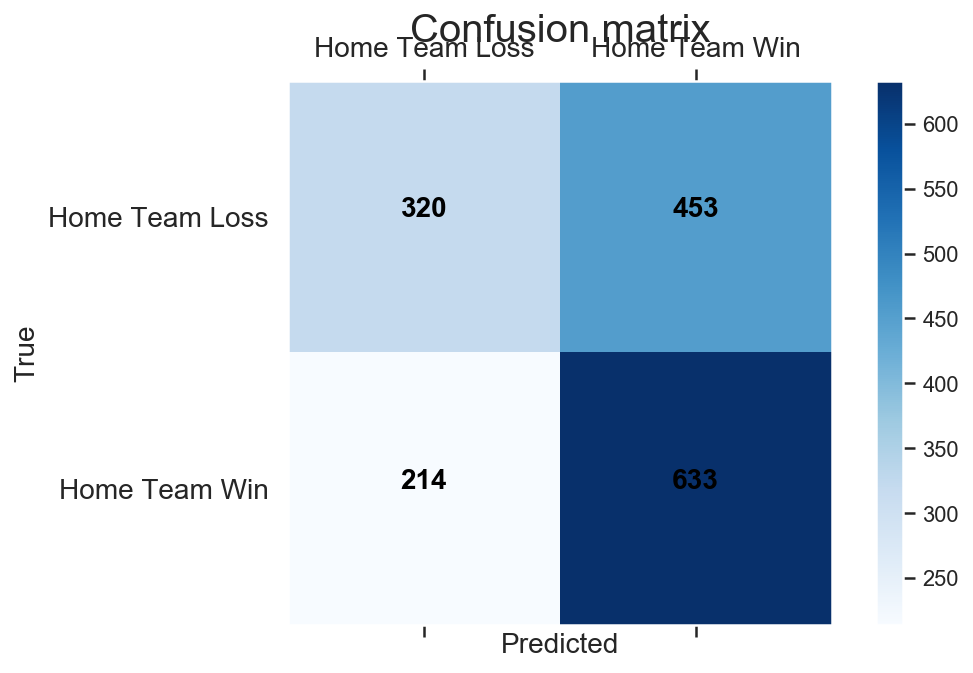

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.5s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.577396,0.567189,0.569753,0.572292,0.571977
recall,0.309211,0.800000,0.569753,0.554605,0.569753
f1-score,0.402742,0.663772,0.569753,0.533257,0.541314
support,760.000000,860.000000,0.569753,1620.000000,1620.000000


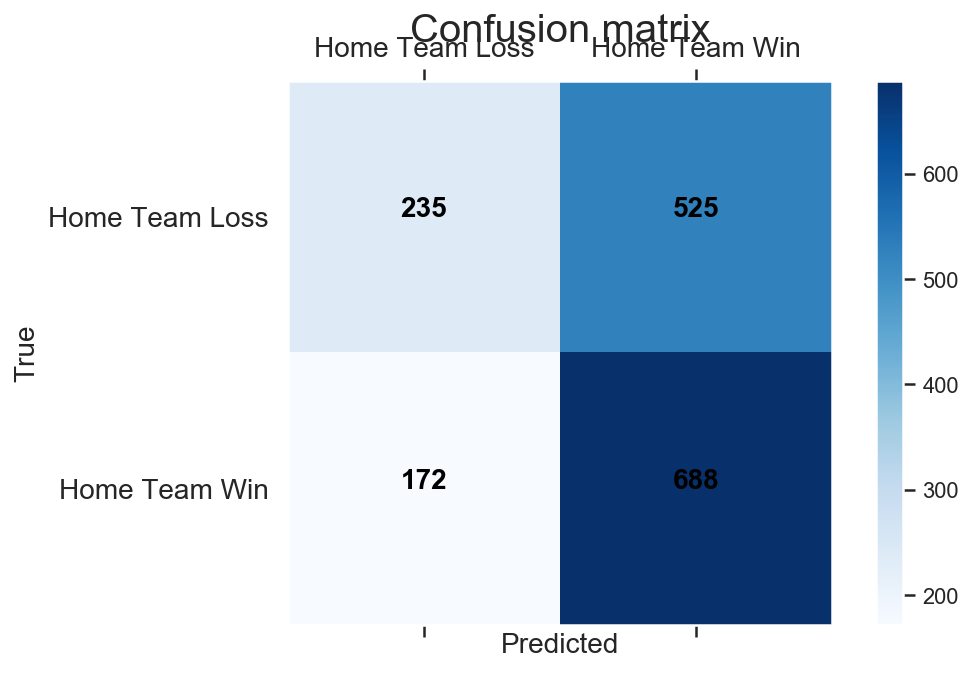

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    7.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.0s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.578558,0.587199,0.584311,0.582878,0.583153
recall,0.412929,0.735192,0.584311,0.574060,0.584311
f1-score,0.481909,0.652914,0.584311,0.567412,0.572851
support,758.000000,861.000000,0.584311,1619.000000,1619.000000


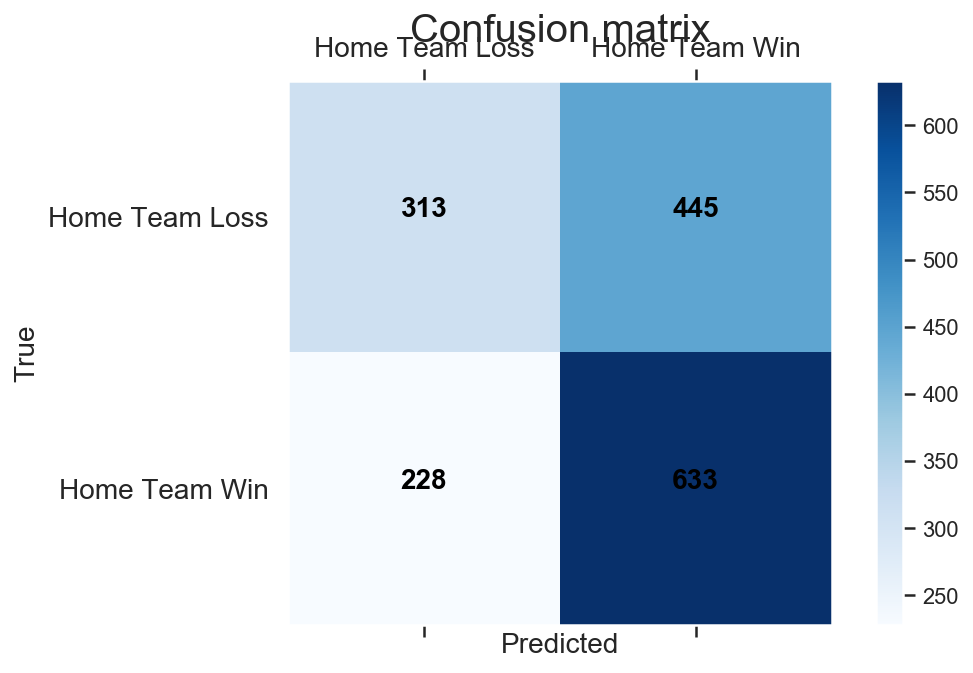

accuracy: 56.98% (+/- 1.11%)
precision: 57.91% (+/- 0.86%)
recall: 76.08% (+/- 2.81%)
f1 score: 65.72% (+/- 0.47%)
roc_auc score: 56.98% (+/- 1.11%)


In [110]:
pipeline_cv(3,X,y,rf_search)

In [112]:
rf_search.best_params_

{'zero_imputer__strategy': 'mean',
 'scaler__with_std': False,
 'scaler__with_mean': False,
 'nan_imputer__strategy': 'mean',
 'interaction__degree': 1,
 'classifier__n_estimators': 141,
 'classifier__min_samples_split': 0.2,
 'classifier__min_samples_leaf': 0.1,
 'classifier__max_features': 111,
 'classifier__max_depth': 30.0,
 'classifier__criterion': 'entropy'}

### Gradient Boost

,0,1,accuracy,macro avg,weighted avg
precision,0.572840,0.576720,0.575103,0.574780,0.574835
recall,0.491525,0.654000,0.575103,0.572763,0.575103
f1-score,0.529076,0.612933,0.575103,0.571005,0.572213
support,472.000000,500.000000,0.575103,972.000000,972.000000


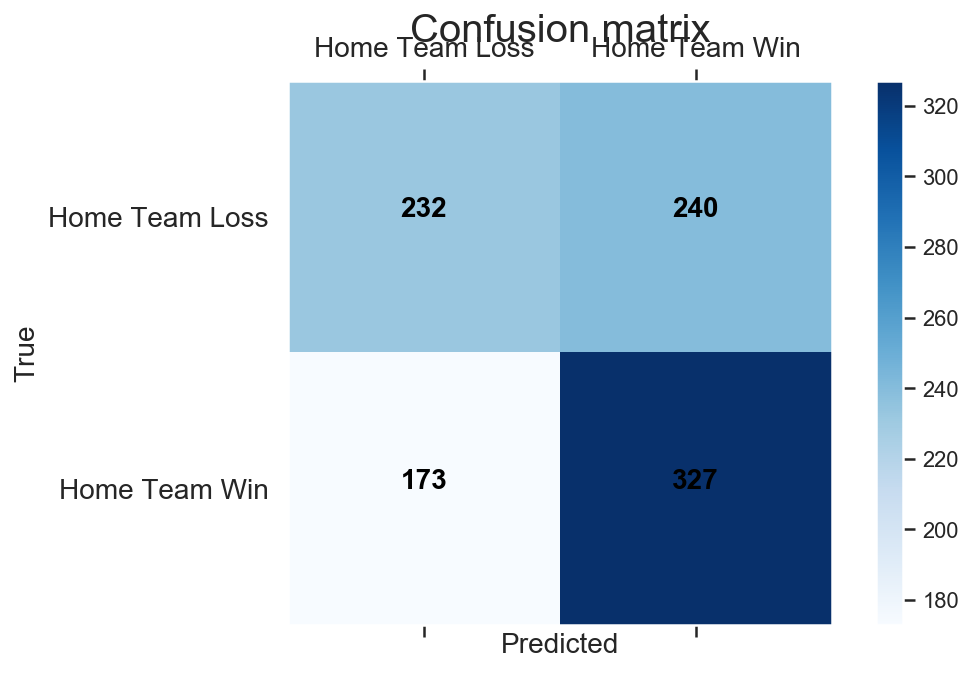

,0,1,accuracy,macro avg,weighted avg
precision,0.527559,0.576988,0.557613,0.552274,0.554053
recall,0.445676,0.654511,0.557613,0.550093,0.557613
f1-score,0.483173,0.613309,0.557613,0.548241,0.552927
support,451.000000,521.000000,0.557613,972.000000,972.000000


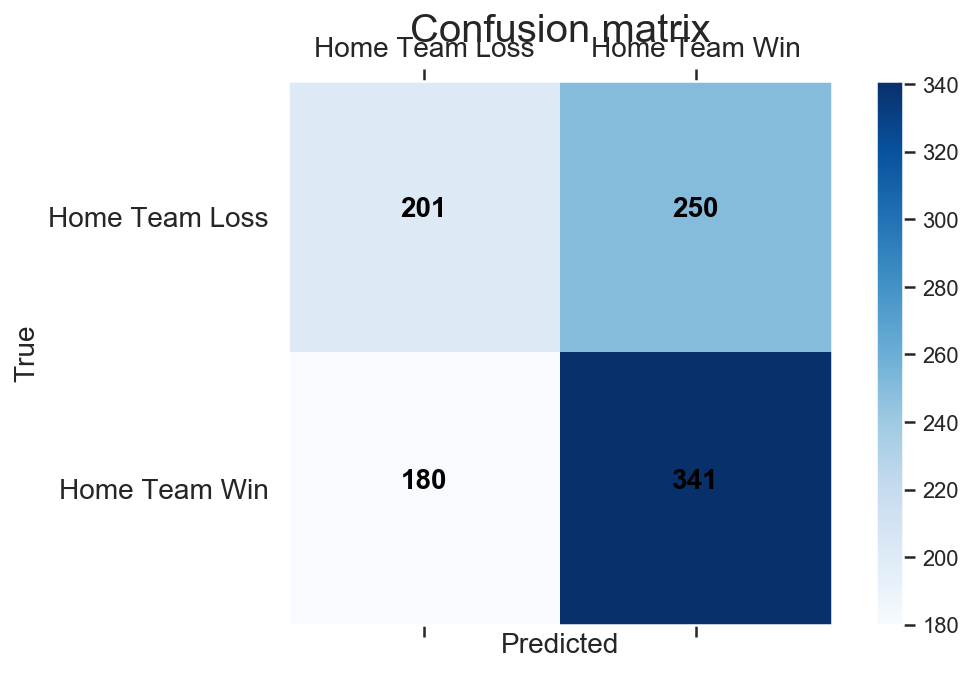

,0,1,accuracy,macro avg,weighted avg
precision,0.548148,0.587302,0.570988,0.567725,0.568933
recall,0.486842,0.645349,0.570988,0.566095,0.570988
f1-score,0.515679,0.614958,0.570988,0.565319,0.568383
support,456.000000,516.000000,0.570988,972.000000,972.000000


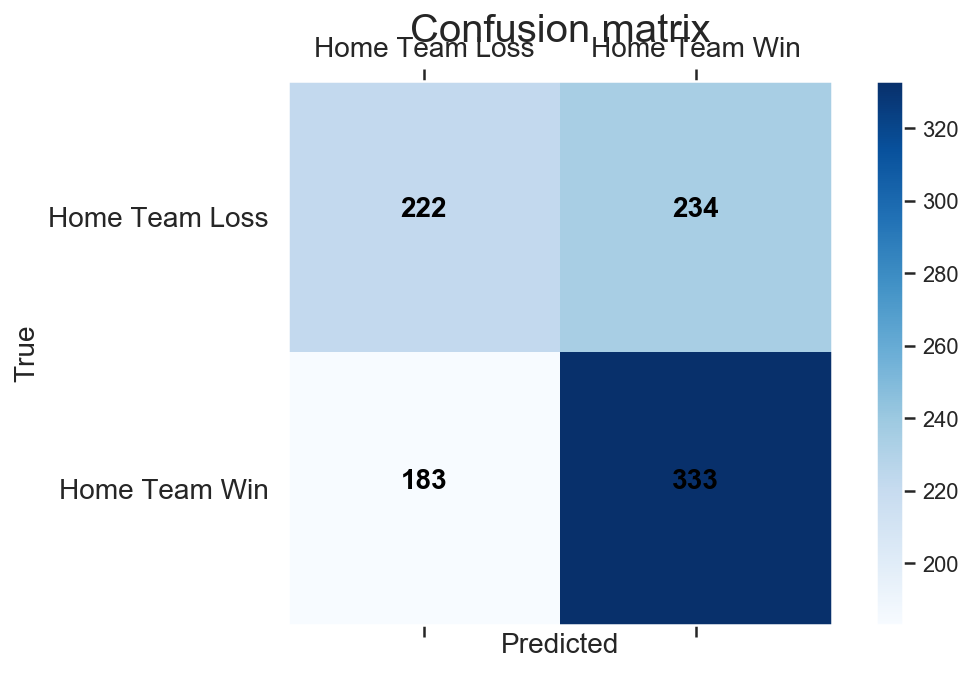

,0,1,accuracy,macro avg,weighted avg
precision,0.561453,0.579805,0.573045,0.570629,0.571138
recall,0.437908,0.693957,0.573045,0.565933,0.573045
f1-score,0.492044,0.631766,0.573045,0.561905,0.565786
support,459.000000,513.000000,0.573045,972.000000,972.000000


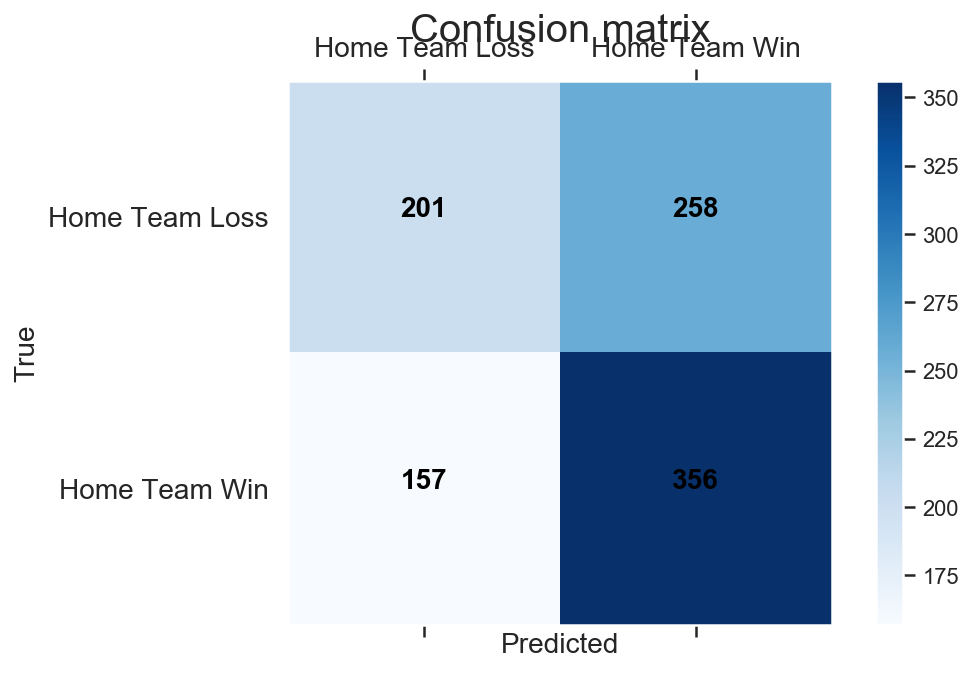

,0,1,accuracy,macro avg,weighted avg
precision,0.529563,0.575601,0.557158,0.552582,0.554123
recall,0.454746,0.646718,0.557158,0.550732,0.557158
f1-score,0.489311,0.609091,0.557158,0.549201,0.553210
support,453.000000,518.000000,0.557158,971.000000,971.000000


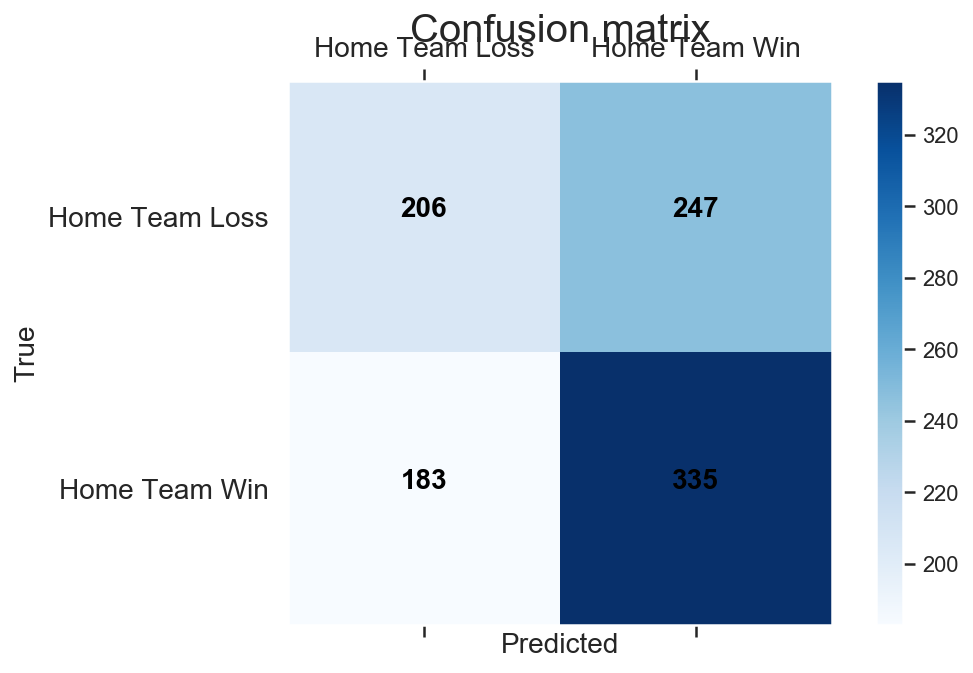

accuracy: 56.68% (+/- 0.78%)
precision: 57.93% (+/- 0.42%)
recall: 65.89% (+/- 1.79%)
f1 score: 61.64% (+/- 0.79%)
roc_auc score: 56.11% (+/- 0.91%)


In [113]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()

gb_pipe=Pipeline([
    ('nan_imputer',SimpleImputer(strategy='mean')),
    ('zero_imputer',SimpleImputer(missing_values=0,strategy='mean')),
    ('interaction',PolynomialFeatures(degree=1)),
    ('scaler',StandardScaler()),
    (('classifier',gb_clf))
])

pipeline_cv(5,X,y,gb_pipe)

In [121]:
gb_search_params = {
    'zero_imputer__strategy':['mean','median','most_frequent'],
    'nan_imputer__strategy':['mean','median','most_frequent'],
    'interaction__degree':[1],
    'scaler__with_std':[False,True],
    'scaler__with_mean':[True,False],
    'classifier__n_estimators':list(range(50,150)),
    'classifier__loss':['deviance','exponential'],
    'classifier__max_depth':np.linspace(1,32,32,endpoint=True),
    'classifier__min_samples_split':np.linspace(0.1, 1.0, 10, endpoint=True),
    'classifier__min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True),
    'classifier__max_features':list(range(1,X.shape[1])),
    'classifier__learning_rate':np.linspace(.1,.9)
}

In [122]:
gb_search = RandomizedSearchCV(gb_pipe,gb_search_params,cv=5,n_jobs=-1,scoring=auc_scorer,verbose=3)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    7.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.5s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.586260,0.596891,0.592593,0.591575,0.591818
recall,0.496766,0.680047,0.592593,0.588407,0.592593
f1-score,0.537815,0.635762,0.592593,0.586788,0.589025
support,773.000000,847.000000,0.592593,1620.000000,1620.000000


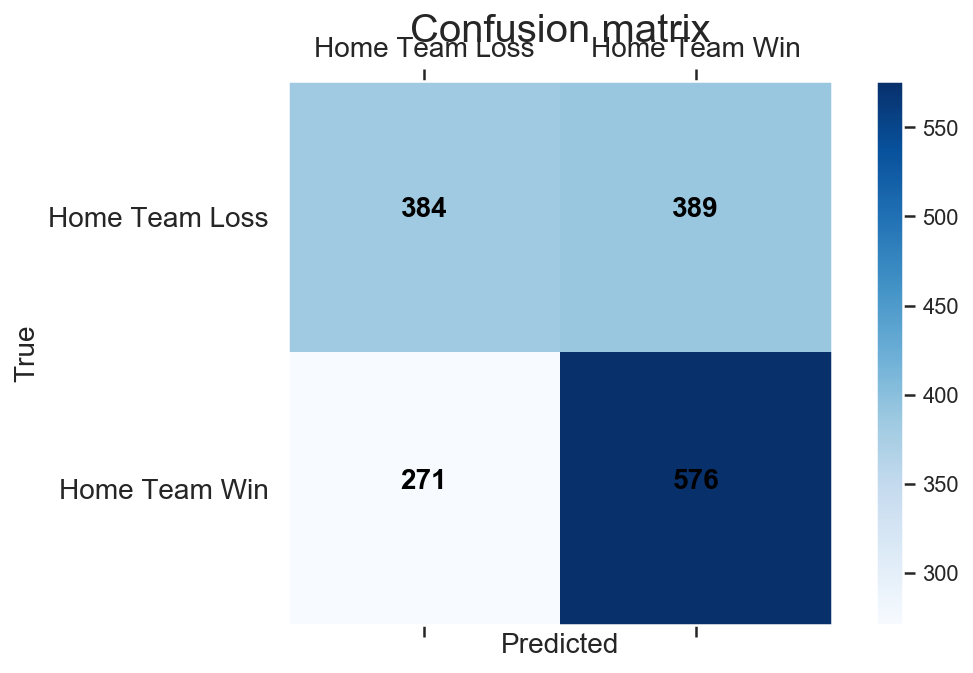

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   15.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.7s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.520958,0.567227,0.548148,0.544092,0.545521
recall,0.457895,0.627907,0.548148,0.542901,0.548148
f1-score,0.487395,0.596026,0.548148,0.541711,0.545064
support,760.000000,860.000000,0.548148,1620.000000,1620.000000


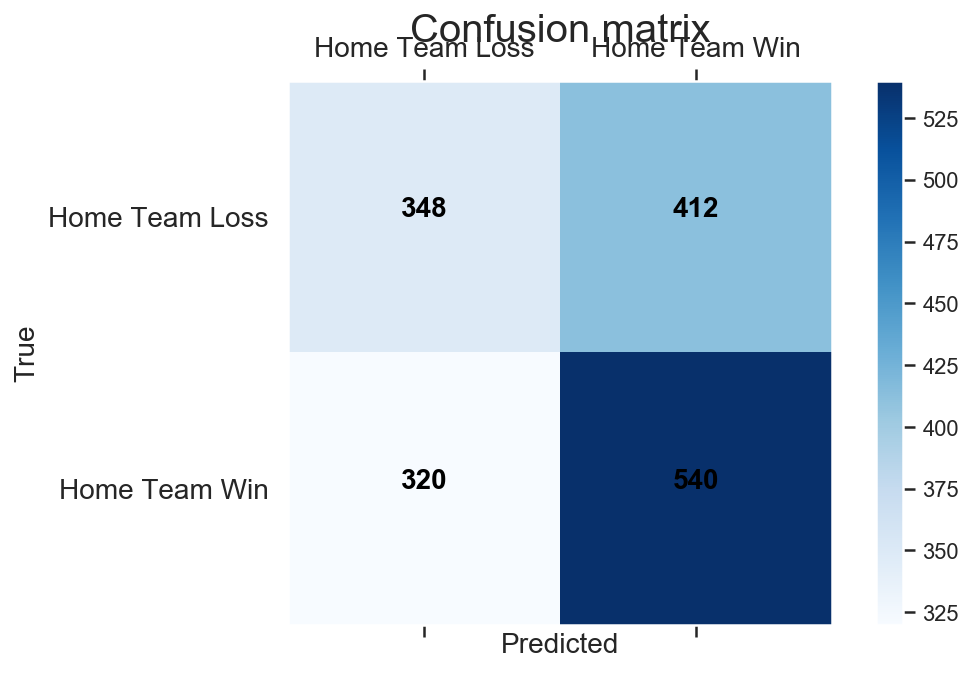

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    8.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.3s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.557480,0.589431,0.576899,0.573456,0.574472
recall,0.467018,0.673635,0.576899,0.570327,0.576899
f1-score,0.508256,0.628726,0.576899,0.568491,0.572323
support,758.000000,861.000000,0.576899,1619.000000,1619.000000


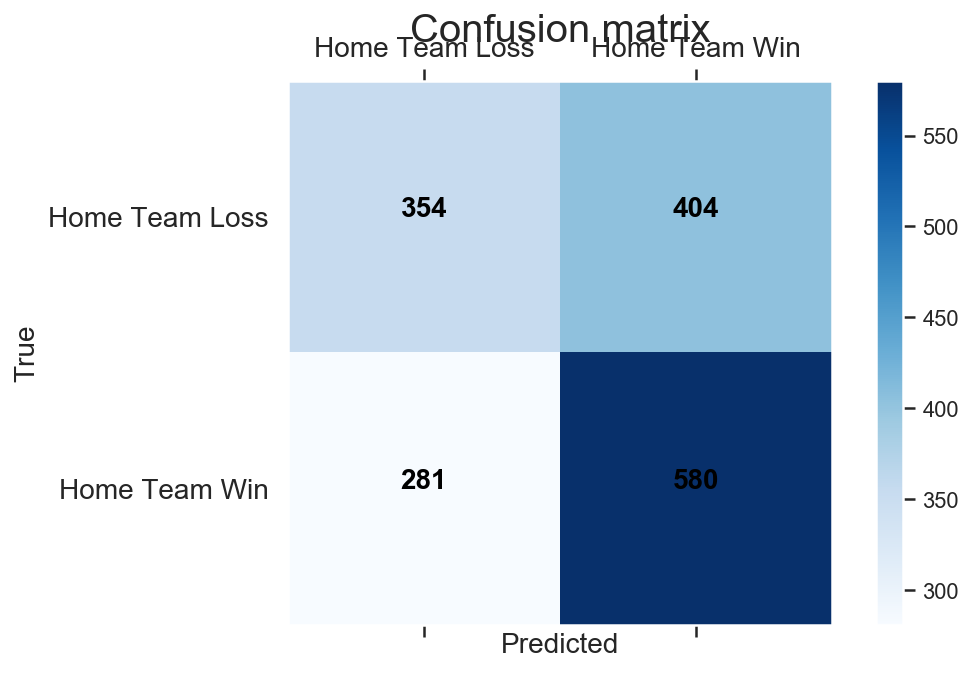

accuracy: 56.72% (+/- 1.87%)
precision: 58.45% (+/- 1.26%)
recall: 66.05% (+/- 2.32%)
f1 score: 62.02% (+/- 1.73%)
roc_auc score: 56.72% (+/- 1.87%)


In [123]:
pipeline_cv(3,X,y,gb_search)

In [124]:
gb_search.best_params_

{'zero_imputer__strategy': 'most_frequent',
 'scaler__with_std': False,
 'scaler__with_mean': True,
 'nan_imputer__strategy': 'most_frequent',
 'interaction__degree': 1,
 'classifier__n_estimators': 84,
 'classifier__min_samples_split': 0.6,
 'classifier__min_samples_leaf': 0.2,
 'classifier__max_features': 36,
 'classifier__max_depth': 30.0,
 'classifier__loss': 'deviance',
 'classifier__learning_rate': 0.2306122448979592}

### examining feature importance

In [125]:
lr_estimator_classifier = lr_search.best_estimator_.named_steps['classifier']

coef_dict = {}
for coef, feat in zip(lr_estimator_classifier.coef_[0,:],list(X)):
    coef_dict[feat] = coef

coef_dict

## Voting Classifier 

In [129]:
voting_clf = VotingClassifier(
    estimators=[('lr',lr_search),
                ('rf',rf_search),
                ('gb',gb_search)],
    voting='soft')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    6.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   11.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.9s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.599010,0.595661,0.596914,0.597335,0.597259
recall,0.469599,0.713105,0.596914,0.591352,0.596914
f1-score,0.526468,0.649113,0.596914,0.587791,0.590592
support,773.000000,847.000000,0.596914,1620.000000,1620.000000


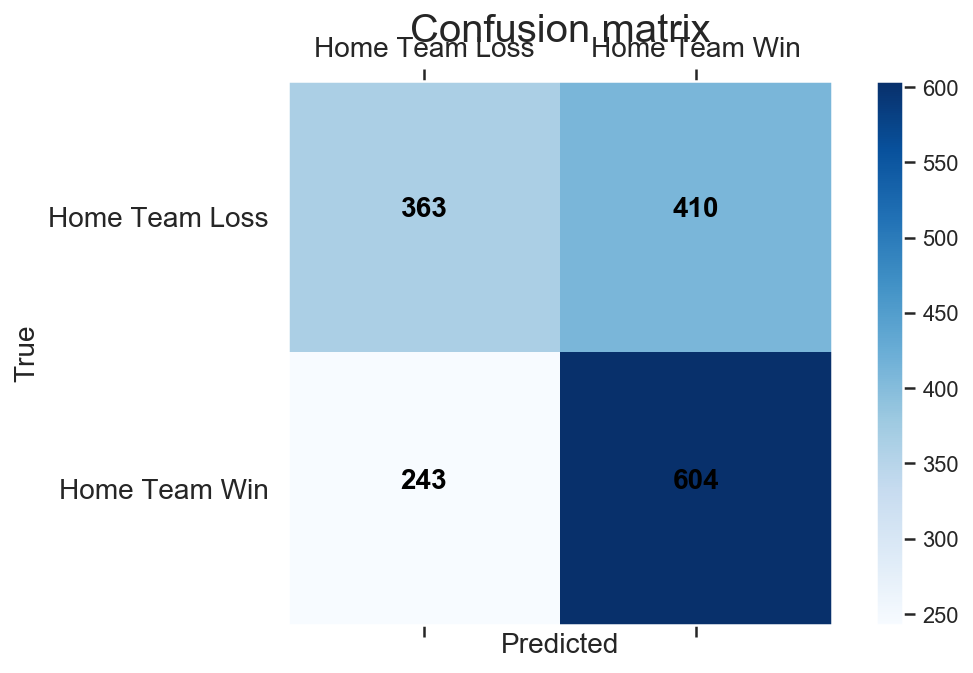

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    7.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.2s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.542808,0.572394,0.561728,0.557601,0.558514
recall,0.417105,0.689535,0.561728,0.553320,0.561728
f1-score,0.471726,0.625527,0.561728,0.548627,0.553374
support,760.000000,860.000000,0.561728,1620.000000,1620.000000


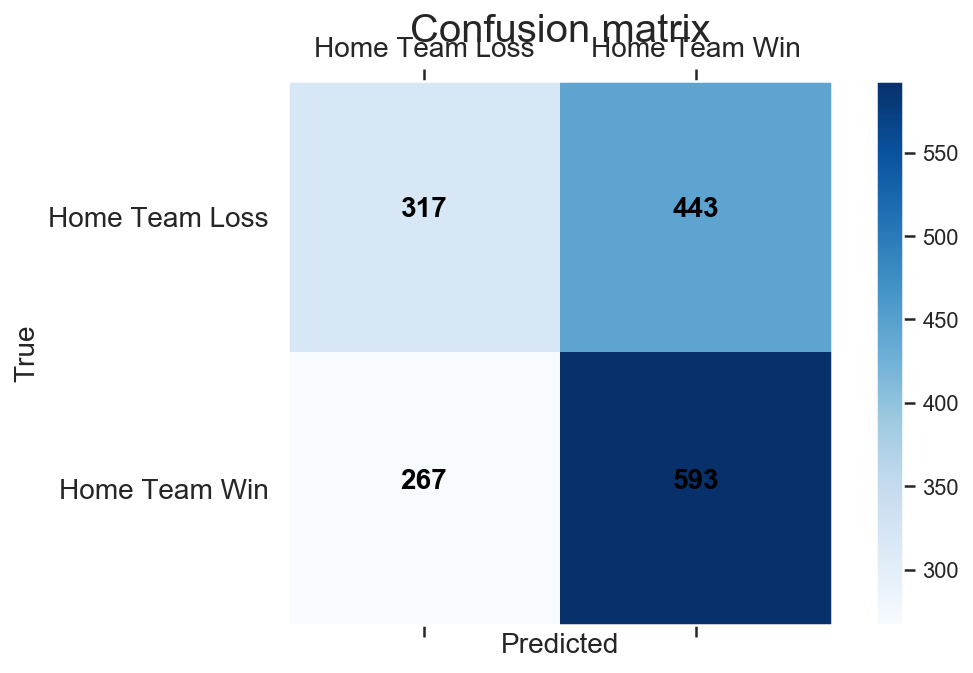

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   16.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    9.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.2s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.574074,0.593171,0.586164,0.583622,0.584230
recall,0.449868,0.706156,0.586164,0.578012,0.586164
f1-score,0.504438,0.644751,0.586164,0.574594,0.579058
support,758.000000,861.000000,0.586164,1619.000000,1619.000000


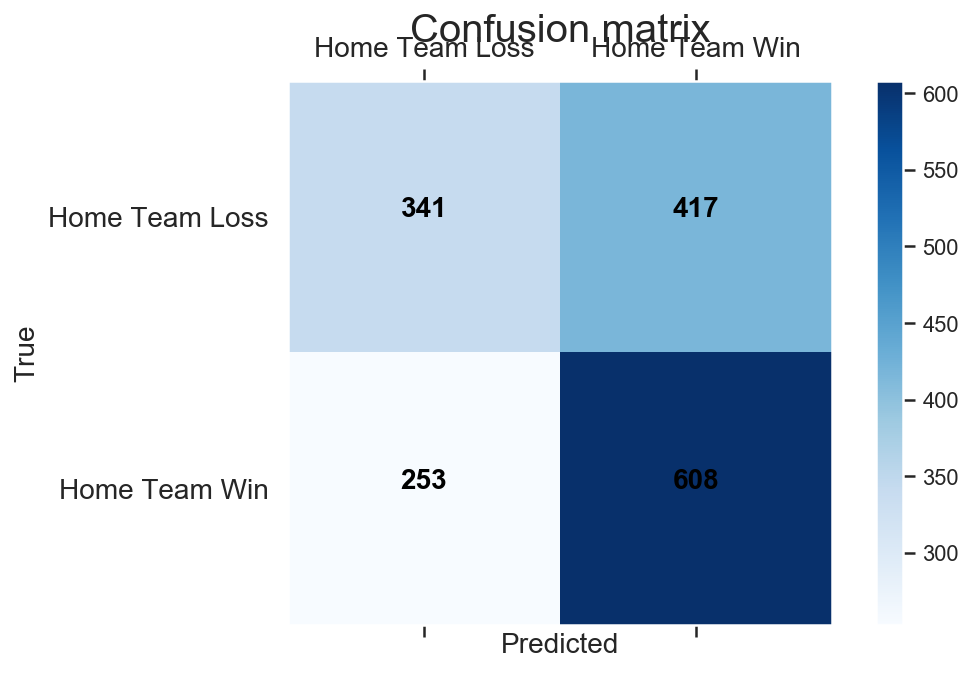

accuracy: 58.16% (+/- 1.47%)
precision: 58.71% (+/- 1.04%)
recall: 70.29% (+/- 0.99%)
f1 score: 63.98% (+/- 1.02%)
roc_auc score: 57.42% (+/- 1.58%)


In [130]:
pipeline_cv(3,X,y,voting_clf)

### Stacking Classifier

In [134]:
from sklearn.ensemble import StackingClassifier

In [135]:
stacking_clf = StackingClassifier(
    estimators=[('lr',lr_search),
                ('rf',rf_search),
                ('gb',gb_search)])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    6.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   13.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    5.4s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   17.1s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:   11.3s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   18.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   13.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    1.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    5.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    9.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    5.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   10.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    9.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.7s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.620053,0.600337,0.608025,0.610195,0.609911
recall,0.497881,0.712000,0.608025,0.604941,0.608025
f1-score,0.552291,0.651418,0.608025,0.601855,0.603283
support,472.000000,500.000000,0.608025,972.000000,972.000000


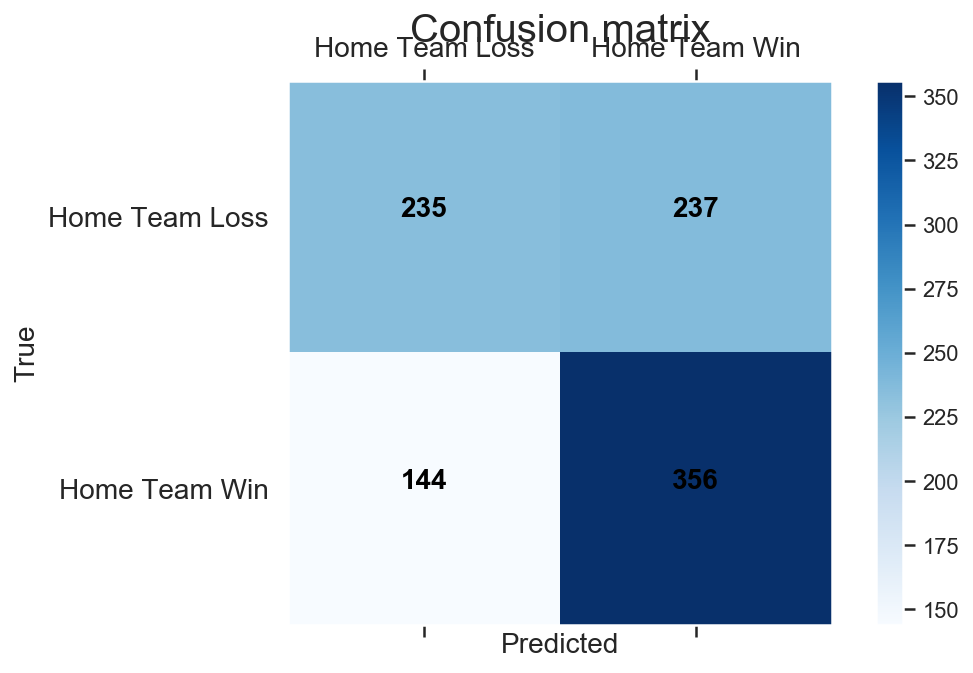

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   17.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   15.7s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    5.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   11.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    9.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    5.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    7.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    9.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.9s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.527174,0.574503,0.556584,0.550839,0.552543
recall,0.430155,0.666027,0.556584,0.548091,0.556584
f1-score,0.473748,0.616889,0.556584,0.545319,0.550473
support,451.000000,521.000000,0.556584,972.000000,972.000000


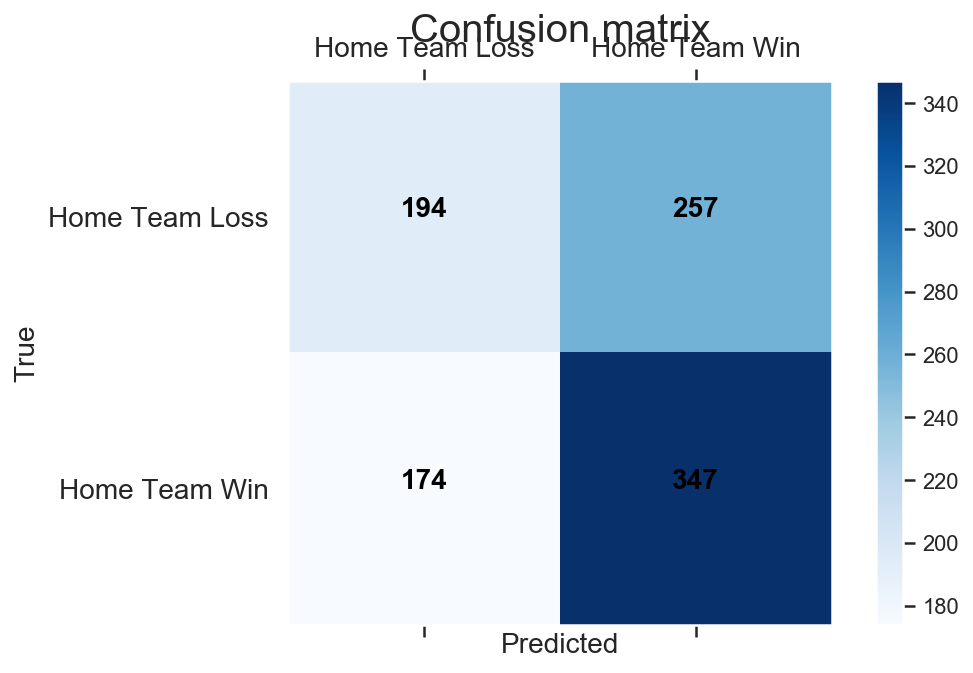

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    7.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    7.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   13.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    8.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   11.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    2.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   17.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    6.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    7.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    6.0s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    6.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    9.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.1s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.569588,0.597603,0.58642,0.583595,0.584460
recall,0.484649,0.676357,0.58642,0.580503,0.586420
f1-score,0.523697,0.634545,0.58642,0.579121,0.582542
support,456.000000,516.000000,0.58642,972.000000,972.000000


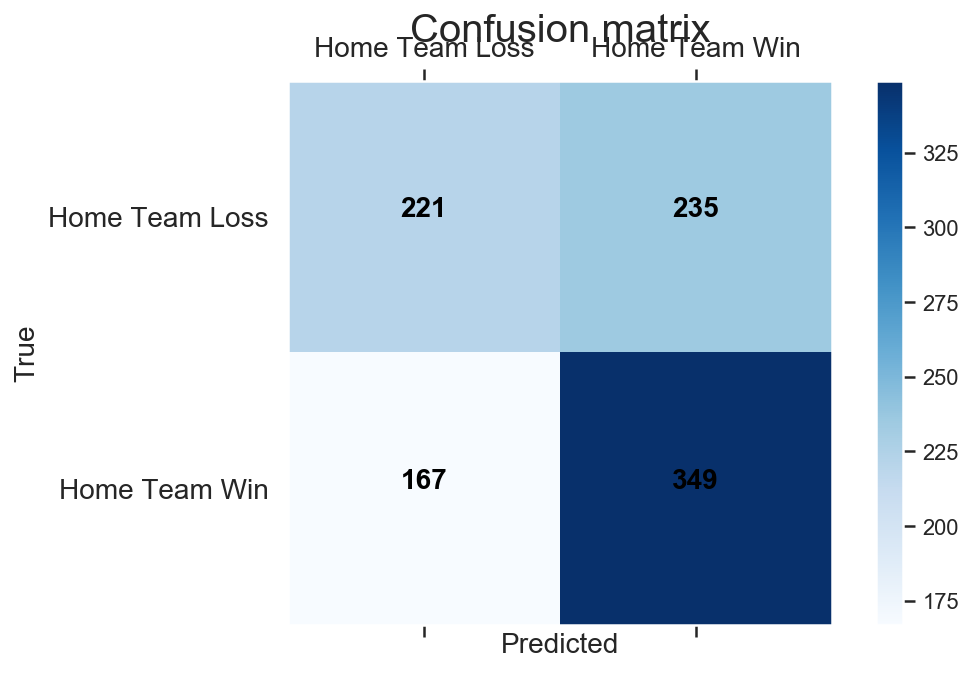

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   12.8s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   23.8s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    6.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   17.3s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    8.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   13.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    7.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    5.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    8.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    7.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.1s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.572700,0.581102,0.578189,0.576901,0.577135
recall,0.420479,0.719298,0.578189,0.569889,0.578189
f1-score,0.484925,0.642857,0.578189,0.563891,0.568278
support,459.000000,513.000000,0.578189,972.000000,972.000000


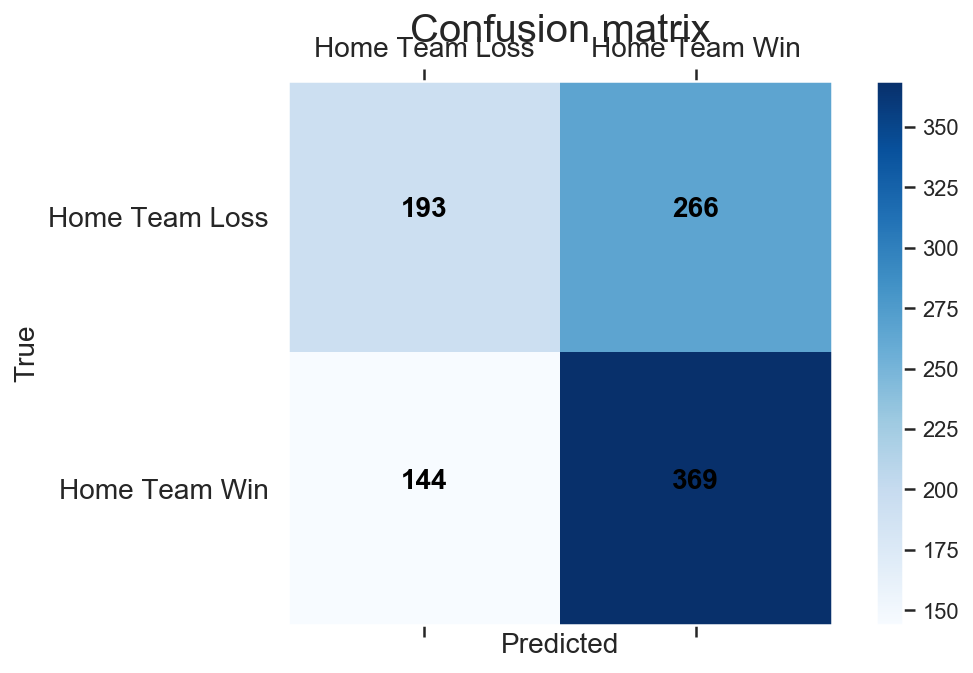

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    8.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    6.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   20.2s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    8.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    5.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    8.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    9.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    7.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    7.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    6.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.0s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.571429,0.596376,0.587024,0.583902,0.584737
recall,0.459161,0.698842,0.587024,0.579001,0.587024
f1-score,0.509180,0.643556,0.587024,0.576368,0.580865
support,453.000000,518.000000,0.587024,971.000000,971.000000


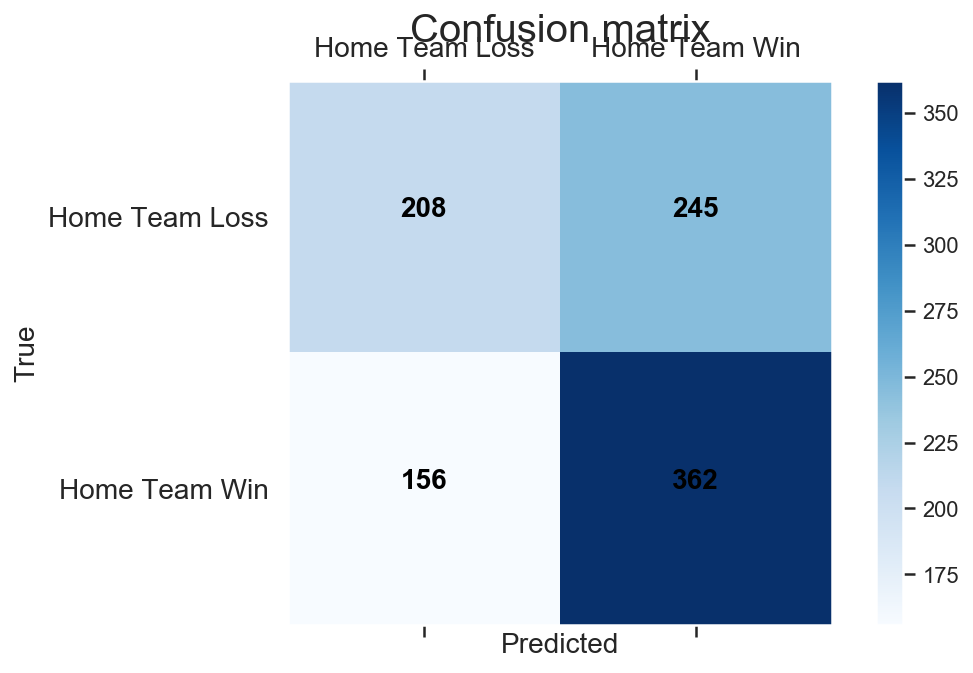

accuracy: 58.32% (+/- 1.66%)
precision: 59.00% (+/- 1.02%)
recall: 69.45% (+/- 2.04%)
f1 score: 63.79% (+/- 1.18%)
roc_auc score: 57.65% (+/- 1.83%)


In [136]:
pipeline_cv(5,X,y,stacking_clf)

In [138]:
lr_search_precision = RandomizedSearchCV(lr_pipe,lr_search_params,cv=3,n_jobs=-1,scoring=precision_scorer,verbose=0)
lr_search_recall = RandomizedSearchCV(lr_pipe,lr_search_params,cv=3,n_jobs=-1,scoring=recall_scorer,verbose=0)
lr_search_f1 = RandomizedSearchCV(lr_pipe,lr_search_params,cv=3,n_jobs=-1,scoring=f1_scorer,verbose=0)

gb_search_precision = RandomizedSearchCV(gb_pipe,gb_search_params,cv=3,n_jobs=-1,scoring=precision_scorer,verbose=0)
gb_search_recall = RandomizedSearchCV(gb_pipe,gb_search_params,cv=3,n_jobs=-1,scoring=recall_scorer,verbose=0)
gb_search_f1 = RandomizedSearchCV(gb_pipe,gb_search_params,cv=3,n_jobs=-1,scoring=f1_scorer,verbose=0)

rf_search_precision = RandomizedSearchCV(rf_pipe,rf_search_params,cv=3,n_jobs=-1,scoring=precision_scorer,verbose=0)
rf_search_recall = RandomizedSearchCV(rf_pipe,rf_search_params,cv=3,n_jobs=-1,scoring=recall_scorer,verbose=0)
rf_search_f1 = RandomizedSearchCV(rf_pipe,rf_search_params,cv=3,n_jobs=-1,scoring=f1_scorer,verbose=0)

In [141]:
stacking_clf_diverseMetrics = StackingClassifier(
    estimators=[('lr',lr_search),
                ('rf',rf_search),
                ('rf_recall',rf_search_recall),
                ('gb_precision',gb_search_precision)])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    6.0s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   12.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    1.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    5.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.596244,0.600408,0.598765,0.598326,0.598421
recall,0.492885,0.695396,0.598765,0.594140,0.598765
f1-score,0.539660,0.644420,0.598765,0.592040,0.594433
support,773.000000,847.000000,0.598765,1620.000000,1620.000000


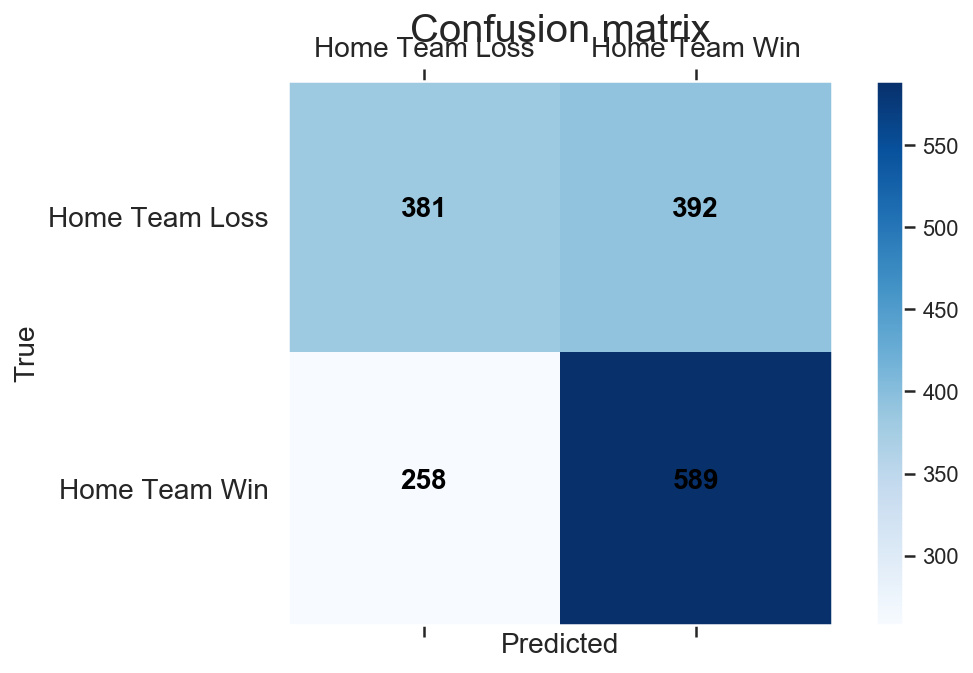

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    6.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   22.8s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    9.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.8s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.537721,0.573721,0.559877,0.555721,0.556832
recall,0.440789,0.665116,0.559877,0.552953,0.559877
f1-score,0.484454,0.616047,0.559877,0.550251,0.554312
support,760.000000,860.000000,0.559877,1620.000000,1620.000000


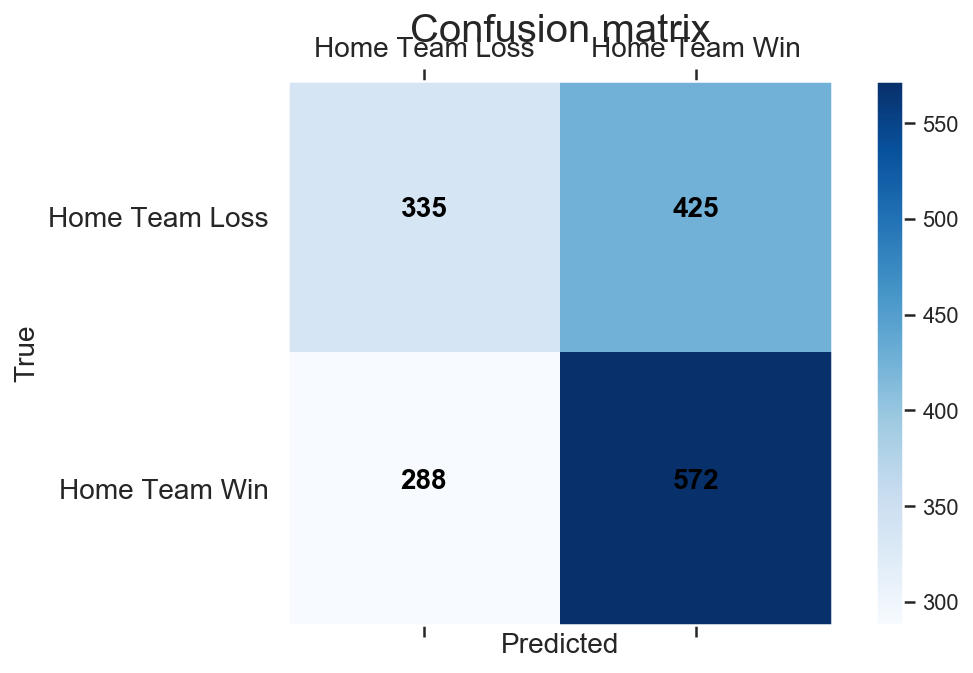

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    6.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    6.6s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   13.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    2.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   12.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   12.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   12.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    4.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.3s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.590291,0.588768,0.589253,0.589530,0.589481
recall,0.401055,0.754936,0.589253,0.577996,0.589253
f1-score,0.477612,0.661578,0.589253,0.569595,0.575447
support,758.000000,861.000000,0.589253,1619.000000,1619.000000


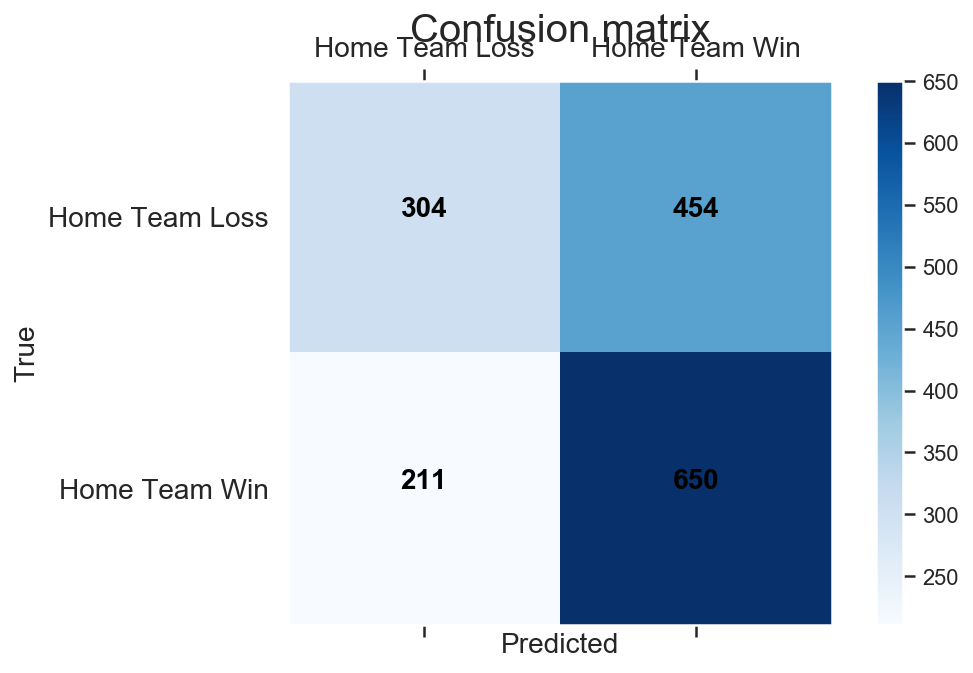

accuracy: 58.26% (+/- 1.66%)
precision: 58.76% (+/- 1.09%)
recall: 70.51% (+/- 3.73%)
f1 score: 64.07% (+/- 1.88%)
roc_auc score: 57.50% (+/- 1.69%)


In [143]:
pipeline_cv(3,X,y,stacking_clf_diverseMetrics)

### PCA

In [ ]:
from sklearn.decomposition import KernelPCA

pca_voting_clf = Pipeline([
    ('kpca',KernelPCA(n_components=2)),
    ('classifier',stacking_clf)
])

### incorporating categorical variables, wind speed and temperature....

In [ ]:
cat_attribs = list(cat_df.drop(columns=['id','temp',
                                        'wind_speed',]))
num_attribs=list(num_df.drop(columns=['ID','home_score','away_score']))
#[num_attribs.append(x) for x in ['temp','wind_speed']]

cat_attribs

num_transform = Pipeline([
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler',StandardScaler(with_mean=False))])

full_transform = ColumnTransformer([
    ('num',num_transform,num_attribs),
    ('cat',OneHotEncoder(handle_unknown='ignore'),cat_attribs),
])

lr_search_transformed=Pipeline([
    ('transformer',full_transform),
    ('classifier',lr_search)
])

